## MNIST

I am just following the example from github

In [1]:
from flax import linen as nn
from flax.training import train_state
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
%matplotlib notebook

In [3]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [4]:
ds_builder = tfds.builder('mnist')
ds_builder.download_and_prepare()
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
test_ds['image'] = jnp.float32(test_ds['image']) / 255.0

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [5]:
rng = jax.random.PRNGKey(666)
rng, init_rng = jax.random.split(rng)

print(rng, init_rng)

[3821355411 1052689499] [ 472701702 1383871100]


### Optimizers

some of the optimizers in optax:

[optimizers](https://optax.readthedocs.io/en/latest/api.html)

we need to call `model.init()` on some dummy input first to initialize the variables

use `train_state.TrainState` with `optax` can save a lot of trouble

In [6]:
def create_train_state(rng, **config):
    cnn = CNN()
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
    tx = optax.adam(config['learning_rate'])
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)


config = {
    'learning_rate': 1e-3,
}
state = create_train_state(rng, **config)
print(state)

TrainState(step=0, apply_fn=<bound method Module.apply of CNN()>, params=FrozenDict({
    Conv_0: {
        kernel: DeviceArray([[[[ 0.05558564,  0.53954107,  0.21765213, -0.2843413 ,
                         0.5001127 ,  0.12845717, -0.06333312,  0.23447926,
                        -0.7232088 ,  0.06534766,  0.2366304 ,  0.40983927,
                         0.02992178,  0.23802339,  0.06768139, -0.20059825,
                        -0.06011359,  0.14001706, -0.3049476 , -0.40396905,
                         0.00248029, -0.15979764,  0.08624008, -0.2323374 ,
                         0.5763062 , -0.480139  , -0.58136696, -0.4526949 ,
                         0.3426432 ,  0.29497358,  0.14419854,  0.1746817 ]],
        
                      [[ 0.08956687, -0.03862143, -0.07583801, -0.07937893,
                        -0.37570345,  0.07470877,  0.66430193,  0.5395574 ,
                         0.17462566, -0.42676768,  0.1237838 , -0.5430477 ,
                         0.04076799, -0.24613

In [7]:
@jax.jit
def apply_model(state, images, labels):
    def loss_fn(params):
        logits = CNN().apply({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy


test_images = train_ds['image'][:32]
test_labels = train_ds['label'][:32]
grads, loss, accuracy = apply_model(state, test_images, test_labels)
print(loss)
print(accuracy)

2.283134
0.0625


In [8]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)


def train_epoch(state, batch_size, indices):
    train_ds_size = len(train_ds['image'])
    steps_per_epoch = train_ds_size // batch_size
    
    perms = jax.random.permutation(indices, len(train_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))
    
    epoch_loss = []
    epoch_accuracy = []
    for perm in perms:
        batch_images = train_ds['image'][perm, ...]
        batch_labels = train_ds['label'][perm, ...]
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


def train_and_evaluate(state):
    rng = jax.random.PRNGKey(666)
    for epoch in range(1, 11):
        rng, input_rng = jax.random.split(rng)
        state, train_loss, train_accuracy = train_epoch(state, 128, input_rng)
        _, test_loss, test_accuracy = apply_model(state, test_ds['image'], test_ds['label'])
        print('epoch:% 3d, train_loss: %.4f, train_accuracy: %.3f, test_loss: %.4f, test_accuracy: %.2f'
              % (epoch, train_loss, train_accuracy * 100, test_loss, test_accuracy))
    return state


done_state = train_and_evaluate(state)

epoch:  1, train_loss: 0.1780, train_accuracy: 94.860, test_loss: 0.0636, test_accuracy: 0.98
epoch:  2, train_loss: 0.0541, train_accuracy: 98.356, test_loss: 0.0451, test_accuracy: 0.99
epoch:  3, train_loss: 0.0376, train_accuracy: 98.835, test_loss: 0.0321, test_accuracy: 0.99
epoch:  4, train_loss: 0.0284, train_accuracy: 99.124, test_loss: 0.0326, test_accuracy: 0.99
epoch:  5, train_loss: 0.0233, train_accuracy: 99.284, test_loss: 0.0300, test_accuracy: 0.99
epoch:  6, train_loss: 0.0184, train_accuracy: 99.407, test_loss: 0.0247, test_accuracy: 0.99
epoch:  7, train_loss: 0.0151, train_accuracy: 99.514, test_loss: 0.0284, test_accuracy: 0.99
epoch:  8, train_loss: 0.0131, train_accuracy: 99.578, test_loss: 0.0287, test_accuracy: 0.99
epoch:  9, train_loss: 0.0107, train_accuracy: 99.651, test_loss: 0.0261, test_accuracy: 0.99
epoch: 10, train_loss: 0.0089, train_accuracy: 99.728, test_loss: 0.0277, test_accuracy: 0.99


<IPython.core.display.Javascript object>


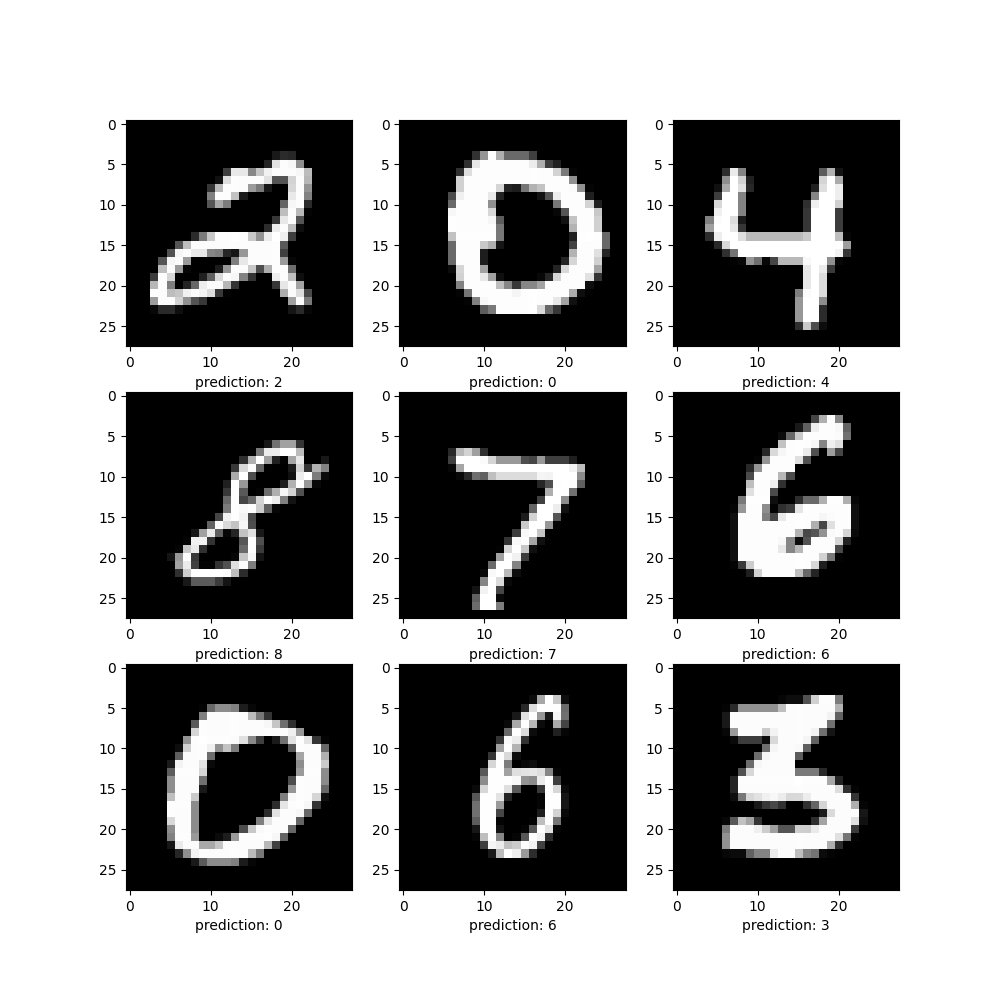

In [9]:
test_images = test_ds['image'][:9, ...]
logits = CNN().apply({'params': done_state.params}, test_images)
prediction = logits.argmax(axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i, :, :, 0], cmap='gray')
    plt.xlabel('prediction: ' + str(prediction[i]))
plt.show()